# Quickstart guide

``imcascade`` is a non-parametric framework for fitting objects in astronomical images. This is accomplished by modelling the objects a series of Gaussians. For full details please read our paper here: *Put ArXiv link here*. What follows is a (very) brief introduction to the basic usage of ``imcascade``.

In [1]:
# This cell is hidden from documentation but the analytic profile and psf are calculated here using the astropy definitions
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling.functional_models import Sersic2D, Moffat2D
from astropy.convolution import convolve
grid = np.arange(0,150)
X,Y = np.meshgrid(grid,grid)
s2d = Sersic2D(r_eff = 5,n = 1.5, x_0 = 75., y_0 = 75.)
im = s2d(X,Y)
im = im*250./np.sum(im)

grid2 = np.arange(0,31)
X,Y = np.meshgrid(grid2,grid2)
m2d = Moffat2D(gamma = 3,alpha = 3, x_0 = 15., y_0 = 15.)
psf = m2d(X,Y)
psf = psf/ np.sum(psf)

sci = convolve(im,psf) + np.random.normal(loc = 0, scale = 5e-2, size = im.shape)

In this short example we will fit an analytic, circular, Sersic profile with $n = 1.5$, $r_e = 5$ and total flux, $F = 200$, we have convolved the profile with a Moffat PSF with $\alpha = 3$ and $\gamma = 3$ and added purely Gaussian noise.

In a hidden cell I have intialized the cutout in the 2D array ``sci`` and the pixelized PSF saved in the 2D array ``psf``. Below I show to 2D images of each

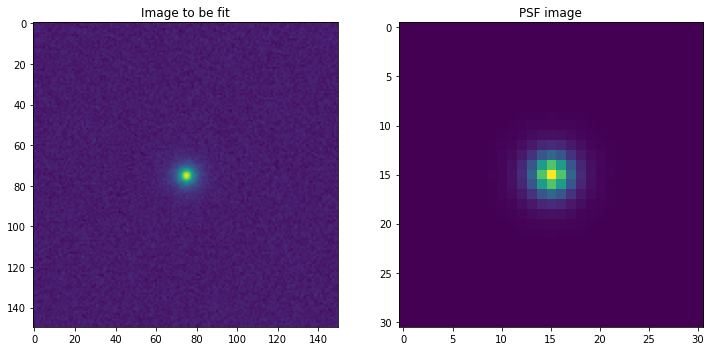

In [2]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize = (12,6))

ax1.imshow(sci)
ax1.set_title('Image to be fit')

ax2.imshow(psf)
ax2.set_title('PSF image')

plt.show()

The ``initialize_fitter`` function is designed to take a pixelized science images (as 2D arrays or fits files) and help initalize a ``Fitter`` instance which will be used below to fit galaxies. This function is designed to help users get started using our experiences to help guide some of the decisions, which may not be applicable in all situations. For more details about these choices or other options please see [the in depth example](example.ipynb) for a longer discussion about all possibilities.

In [3]:
from imcascade.fitter import initialize_fitter

fitter = initialize_fitter(sci,psf)

2021-06-02 15:57:17,874 - Fit PSF with 4 components
2021-06-02 15:57:17,877 - Widths: 1.2,1.81,5.28,2.93
2021-06-02 15:57:17,879 - Fluxes: 0.27,0.51,0.03,0.19
2021-06-02 15:57:17,911 - Using 9 components with logarithmically spaced widths to fit galaxy
2021-06-02 15:57:17,913 - 0.87, 1.39, 2.22, 3.54, 5.64, 8.99, 14.34, 22.87, 36.47
2021-06-02 15:57:17,915 - No mask was given, derriving one using sep
2021-06-02 15:57:17,958 - Using sep rms map to calculate pixel weights


This function uses the ``psf_fitter`` module to fit the given pixelized psf with a sum of Gaussians, which is required for our method. Next it estimates the effective radius and uses nine logarithmically spaced widths for the Gaussian components ranging from the PSF HWHM to $10\times r_e$. It then derrives pixel weights and masks using [sep](https://sep.readthedocs.io/en/v1.1.x/) (or the gain,exposure time and readnoise to calculate the rms). There are also options to use pre-calculated version of these if the user has them.

Now we will run our least-squares minimization routine

In [4]:
opt_param = fitter.run_ls_min()
print (opt_param)

2021-06-02 15:57:24,962 - Running least squares minimization
2021-06-02 15:58:26,970 - Finished least squares minimization


[ 7.59877189e+01  7.49597048e+01  9.74259034e-01  1.51498459e+00
  1.41344796e+00 -2.78423788e+00  1.30517731e+00  1.73765215e+00
  1.69045057e+00  1.63997099e+00 -2.79204666e+00 -2.79219698e+00
 -2.79219756e+00 -8.77719934e-05  8.05490933e-06  5.59552332e-06]


We have printed out the parameters the desribe the best fit model. The first four are the structural parameters (x position, y position, axis ratio and position angle) then the next nine represent the fluxes or weights of the nine components (in logarithmic space) and the final three parameters for the tilted-plane sky model.

Obviously this is non-trivial to parse, which is why we will use our ``results`` module and the ``ImcascadeResults`` class to help us analyze the results

In [5]:
from imcascade.results import ImcascadeResults
res_ls = ImcascadeResults(fitter)
res_ls.run_basic_analysis()

{'flux': 193.44242062476053,
 'r20': 1.8099911828165522,
 'r50': 4.739854050401768,
 'r80': 9.450997069887732,
 'r90': 12.875583509177192,
 'C80_20': 5.221570778693466,
 'C90_50': 2.71645147134558}

We can see our fit matches the true profile pretty well!

Next we will explore the Posterior distribution using Dynesty, and our method of pre-rendered images to help speed up the run time.

In [6]:
post = fitter.run_dynesty(method = 'express')

2021-06-02 15:58:27,045 - Running dynesty using the express method
2021-06-02 15:58:27,048 - Setting up pre-rendered images
2021-06-02 15:58:27,051 - Parameters to be set for pre-rendered images:
2021-06-02 15:58:27,052 - 	 Galaxy Center: 75.99,74.96
2021-06-02 15:58:27,055 - 	 Axis Ratio: 0.97426
2021-06-02 15:58:27,057 - 	 PA: 1.51498
iter: 27551 | batch: 8 | bound: 313 | nc: 25 | ncall: 655299 | eff(%):  4.204 | loglstar: 35428.150 < 35437.243 < 35436.252 | logz: 35420.525 +/-  0.220 | stop:  0.918                               2021-06-02 16:26:13,866 - Finished running dynesty, calculating posterier


Now if we run the analysis again, we will have slightly different central values and error as the 16th-84th percentile range of the posterior.

In [7]:
res_dyn = ImcascadeResults(fitter)
res_dyn.run_basic_analysis()

{'flux': array([193.4481749 ,   2.11287567,   2.15796168]),
 'r20': array([1.80815698, 0.03861177, 0.03768717]),
 'r50': array([4.74502122, 0.06915568, 0.07058949]),
 'r80': array([9.44350851, 0.19677958, 0.21464335]),
 'r90': array([12.90316249,  0.4077762 ,  0.41033308]),
 'C80_20': array([5.2253014 , 0.11777567, 0.12765788]),
 'C90_50': array([2.71948448, 0.06136983, 0.06029801])}